<font color='green' size='7'>**Промежуточная аттестация 2**</font>  
<font color='#11a642' size='6'>**Тема: Временные ряды**</font>  
<font size='5'>**Задание:**</font>  

Домашняя работа основана на лекции и семинаре по Временным рядам.

Данные для домашнего задания прикреплены в Дополнительных материалах.





**Описание плана работы**

1. Загрузка данных. Убедиться, что дата является индексом датасета.
2. Провести разведочный анализ данных (EDA).
3. Провести тест на стационарность ряда. Сделать вывод о стационарности.
4. Разделить данные на тестовую и тренировочную выборку.
5. Автоматически подобрать параметры для ряда с помощью auto_arima. Выбрать оптимальные значения.
7. Построить и обучить модель ARIMA, используя p,d,q из полученного результата по auto_arima. Построить прогноз для тестового набора данных. Оценить модель ARIMA.
8. Разложить на тренд и сезонность с помощью prophet. Оценить модель prophet
9. Сравнить модель ARIMA и prophet. Выбрать лучшую


# <font color='#11a642' size='6'> Импорт и установка библиотек



In [1]:
# установка дополнительной библиотеки
!pip install numpy==1.26.4
!pip install pmdarima

In [2]:
!pip install matplotlib
!pip install statsmodels
!pip install seaborn
!pip install scikit-learn
!pip install pandas
!pip install prophet


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd # работа с таблицами
import numpy as np # математические вычисления
from scipy import stats # статистические методы
import matplotlib
import matplotlib.pyplot as plt # визуализация данных
import seaborn as sns


from statsmodels.tsa.stattools import adfuller # тест Дики-Фуллера
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
import prophet # библиотека Prophet для прогнозирования временных рядов
from prophet import Prophet
from pmdarima import auto_arima # автоматический подбор параметров

c:\Users\alexander\Desktop\python_innopolis_ml\part_2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# <font color='#11a642' size='6'> Загрузка данных


In [4]:
!gdown 1XFoZrWweyXM4kO9JWitNyAp50yySiMx_

Downloading...
From: https://drive.google.com/uc?id=1XFoZrWweyXM4kO9JWitNyAp50yySiMx_
To: c:\Users\alexander\Desktop\python_innopolis_ml\part_2\practice_work\Electric_Production.csv

  0%|          | 0.00/7.32k [00:00<?, ?B/s]
100%|██████████| 7.32k/7.32k [00:00<00:00, 35.7MB/s]


In [5]:
try:
  df = pd.read_csv('Electric_Production.csv')
except:
  df = pd.read_csv('/content/Electric_Production.csv')

df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df.rename(columns={'IPG2211A2N': 'Electric_Production'}, inplace=True)


In [6]:
df.head()

,Electric_Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


# <font color='#11a642' size='6'> Провести разведочный анализ данных (EDA)

- Анализ пропусков и выбросов


Размер датасета: 0.0000 ГБ
Количество строк: 397
Количество столбцов: 1
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Electric_Production  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB

Пропуски в данных: 0


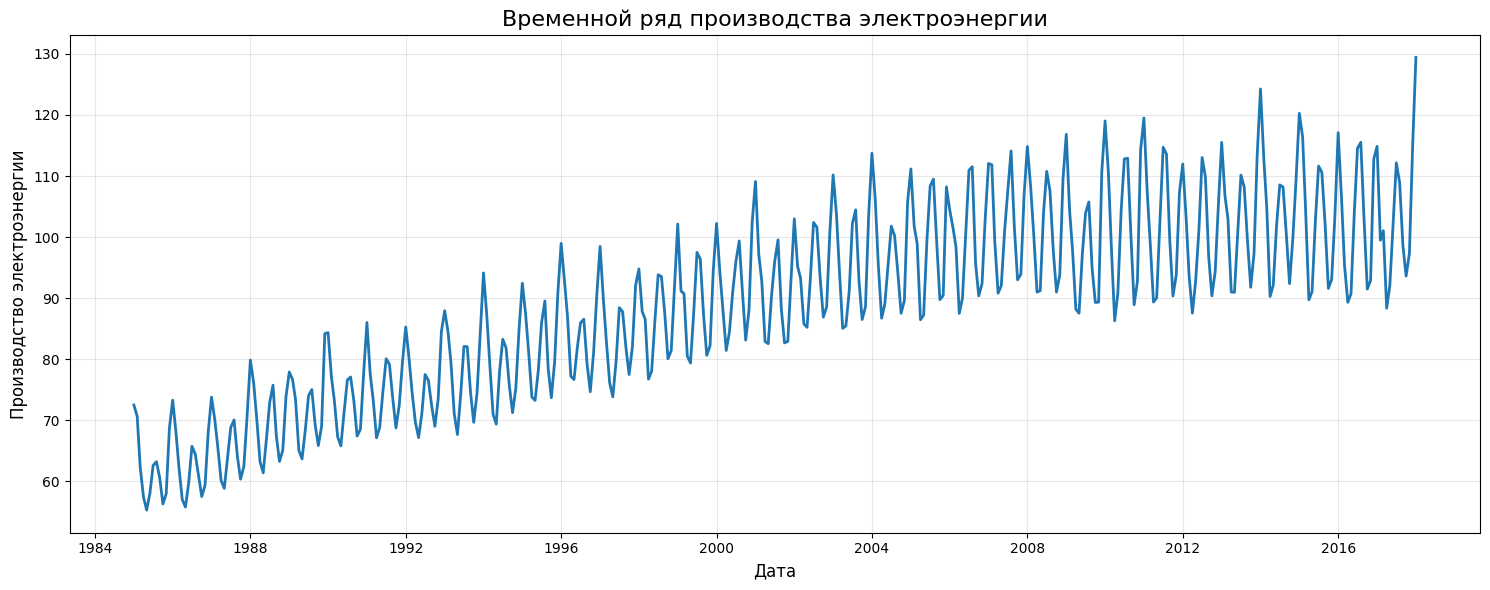

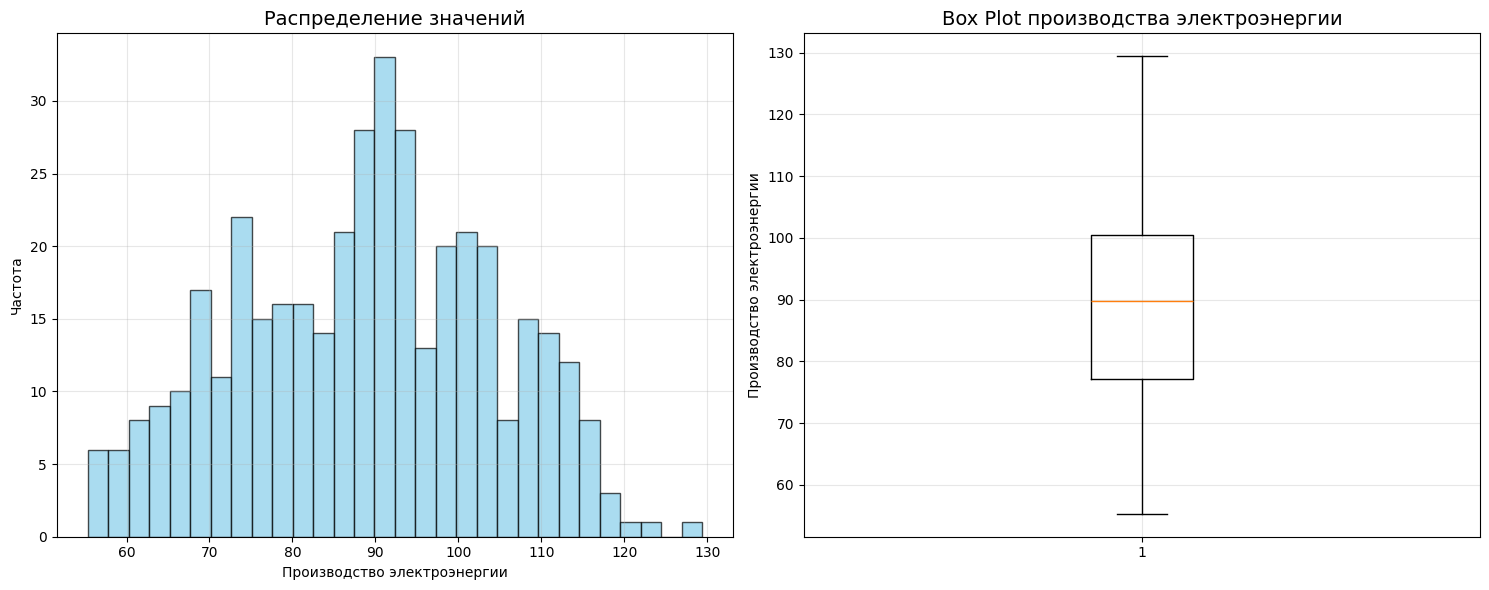


Выбросы (по методу IQR): 0 значений


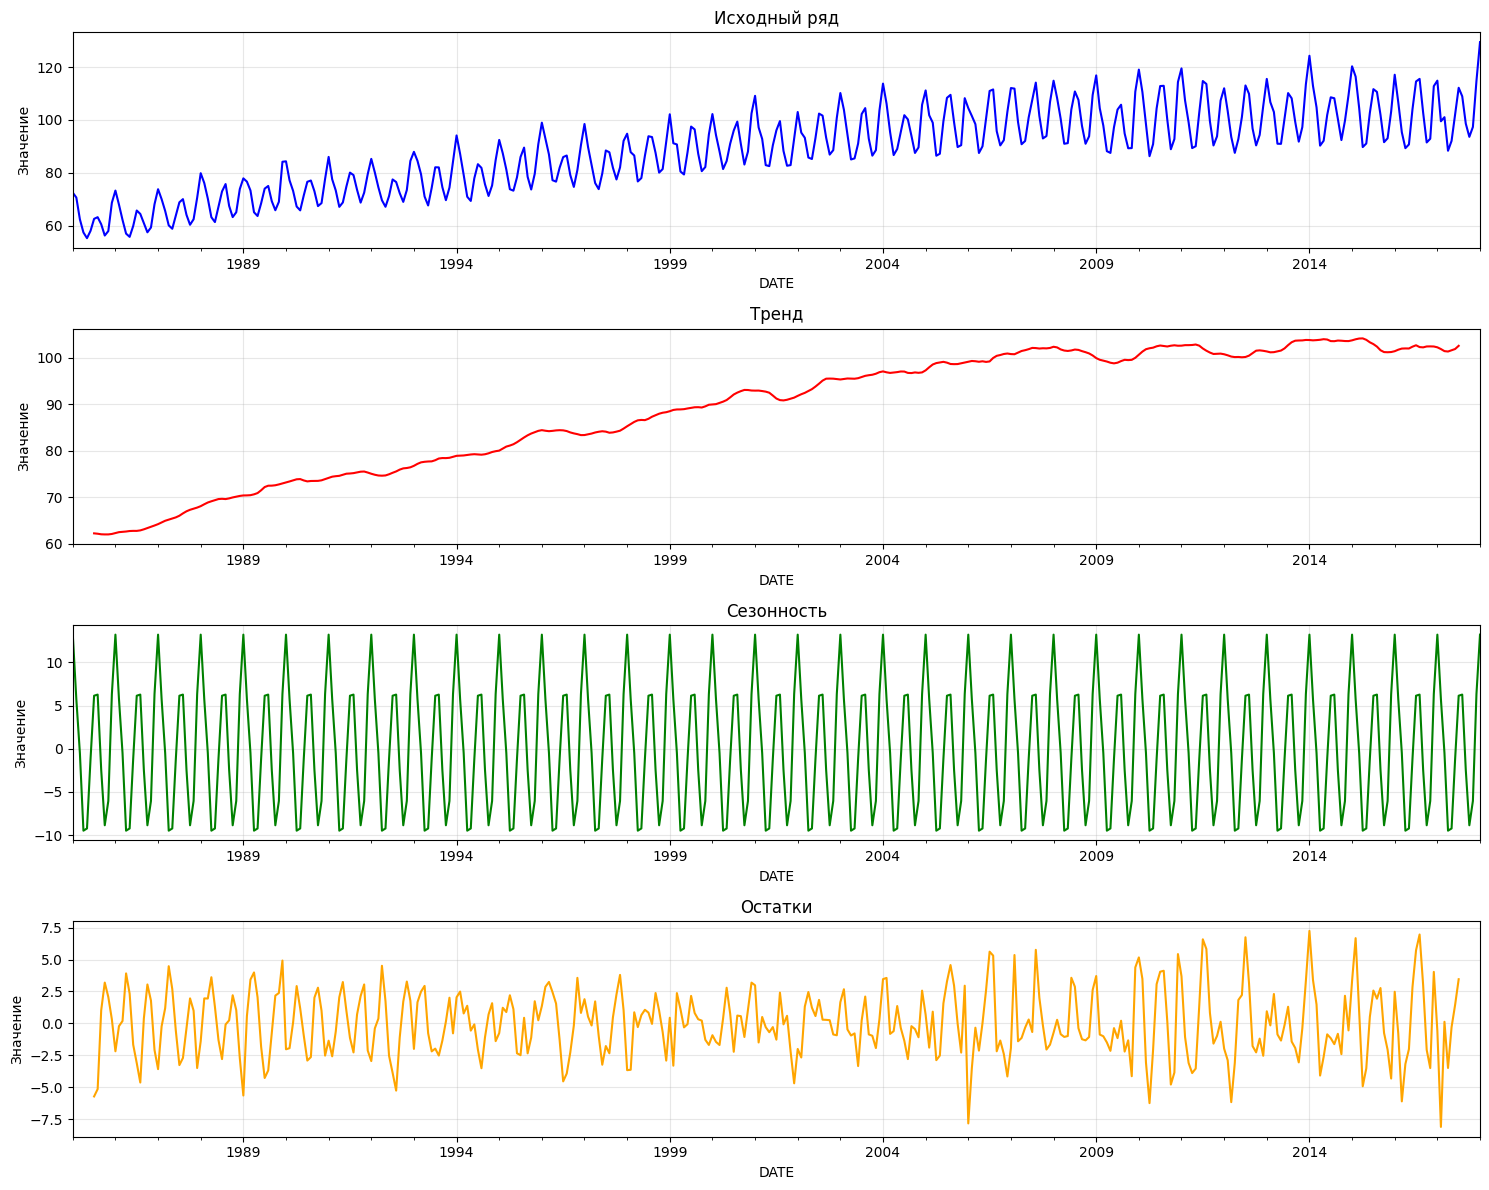

In [7]:
# ваш код
dataset_size_gb = df.memory_usage(deep=True).sum() / (1024**3)
print(f"Размер датасета: {dataset_size_gb:.4f} ГБ")
print(f"Количество строк: {df.shape[0]}")
print(f"Количество столбцов: {df.shape[1]}")

df.info()

# Описательная статистика
df.describe()

# Анализ пропусков
print(f"\nПропуски в данных: {df.isnull().sum().sum()}")

# Визуализация временного ряда
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Electric_Production'], linewidth=2)
plt.title('Временной ряд производства электроэнергии', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Производство электроэнергии', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Гистограмма и box plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Гистограмма
ax1.hist(df['Electric_Production'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Распределение значений', fontsize=14)
ax1.set_xlabel('Производство электроэнергии')
ax1.set_ylabel('Частота')
ax1.grid(True, alpha=0.3)

# Box plot
ax2.boxplot(df['Electric_Production'])
ax2.set_title('Box Plot производства электроэнергии', fontsize=14)
ax2.set_ylabel('Производство электроэнергии')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ выбросов
Q1 = df['Electric_Production'].quantile(0.25)
Q3 = df['Electric_Production'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Electric_Production'] < lower_bound) | (df['Electric_Production'] > upper_bound)]
print(f"\nВыбросы (по методу IQR): {len(outliers)} значений")
if len(outliers) > 0:
    print("Даты с выбросами:")
    print(outliers.index.strftime('%Y-%m-%d').tolist())

# Сезонная декомпозиция
decomposition = seasonal_decompose(df['Electric_Production'], model='additive', period=12)
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0], title='Исходный ряд', color='blue')
decomposition.trend.plot(ax=axes[1], title='Тренд', color='red')
decomposition.seasonal.plot(ax=axes[2], title='Сезонность', color='green')
decomposition.resid.plot(ax=axes[3], title='Остатки', color='orange')

for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.set_ylabel('Значение')

plt.tight_layout()
plt.show()

# <font color='#11a642' size='6'> Провести анализ временного ряда

## <font color='#11a642' size='5'>Автокорреляция

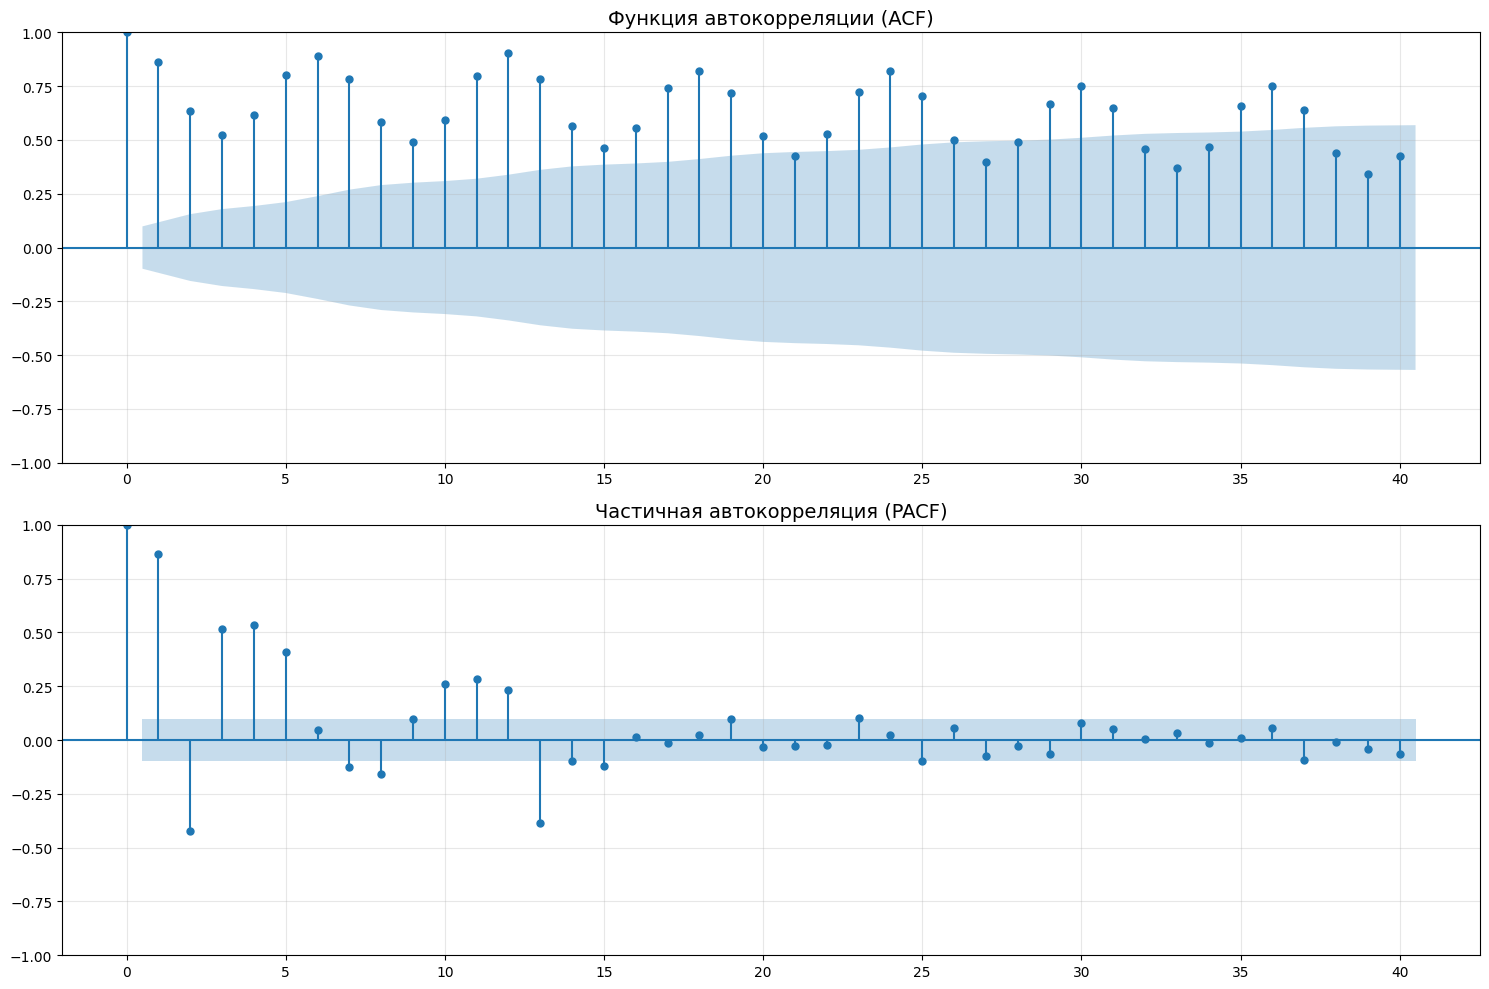

In [8]:
# ваш код

# Автокорреляция
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

plot_acf(df['Electric_Production'], ax=ax1, lags=40, alpha=0.05)
ax1.set_title('Функция автокорреляции (ACF)', fontsize=14)
ax1.grid(True, alpha=0.3)

plot_pacf(df['Electric_Production'], ax=ax2, lags=40, alpha=0.05)
ax2.set_title('Частичная автокорреляция (PACF)', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## <font color='#11a642' size='5'>Частичная автокорреляция

# <font color='#11a642' size='6'> Провести тест на стационарность ряда

In [9]:
def adf_test(series,title=''):
  '''
  тест Дики-Фуллера
  0 гипотеза: ряд данных не стационарен
  альтернативная гипотеза: ряд данных стационарен
  Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда
  @param series - значения ряда
  @param title - заголовок ряда
  '''

  result = adfuller(series.dropna(),autolag='AIC')

  labels = ['ADF тест','p-value','# lags used','# наблюдения']
  out = pd.Series(result[0:4],index=labels)

  for key,val in result[4].items():
      out[f'критическое значение ({key})']=val

  print(out.to_string())

  if result[1] <= 0.05:
      print("Сильные доказательства против нулевой гипотезы")
      print("Отменяем 0 гипотезу")
      print("Данные стационарны")
  else:
      print("Слабые доказательства против нулевой гипотезы")
      print("Не отменяем 0 гипотезу")
      print("Данные не стационарны")

In [10]:
adf_test(df['Electric_Production'])

ADF тест                       -2.256990
p-value                         0.186215
# lags used                    15.000000
# наблюдения                  381.000000
критическое значение (1%)      -3.447631
критическое значение (5%)      -2.869156
критическое значение (10%)     -2.570827
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


In [11]:
# ваш код
# Если ряд не стационарен, применяем дифференцирование
if not is_stationary:
    print("\nПрименяем дифференцирование первого порядка:")
    df['Electric_Production_diff'] = df['Electric_Production'].diff()
    
    # Тест на дифференцированном ряду
    is_stationary_diff = adf_test(df['Electric_Production_diff'].dropna(), 'дифференцированный ряд')
    
    # Визуализация дифференцированного ряда
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df['Electric_Production_diff'], linewidth=2, color='orange')
    plt.title('Дифференцированный временной ряд', fontsize=16)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Разность производства электроэнергии', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

NameError: name 'is_stationary' is not defined

Сделать вывод о стационарности:

# <font color='#11a642' size='6'> Разделить данные на тестовую и тренировочную выборку

Размер тренировочной выборки: 317 (1985-01-01 00:00:00 - 2011-05-01 00:00:00)
Размер тестовой выборки: 80 (2011-06-01 00:00:00 - 2018-01-01 00:00:00)


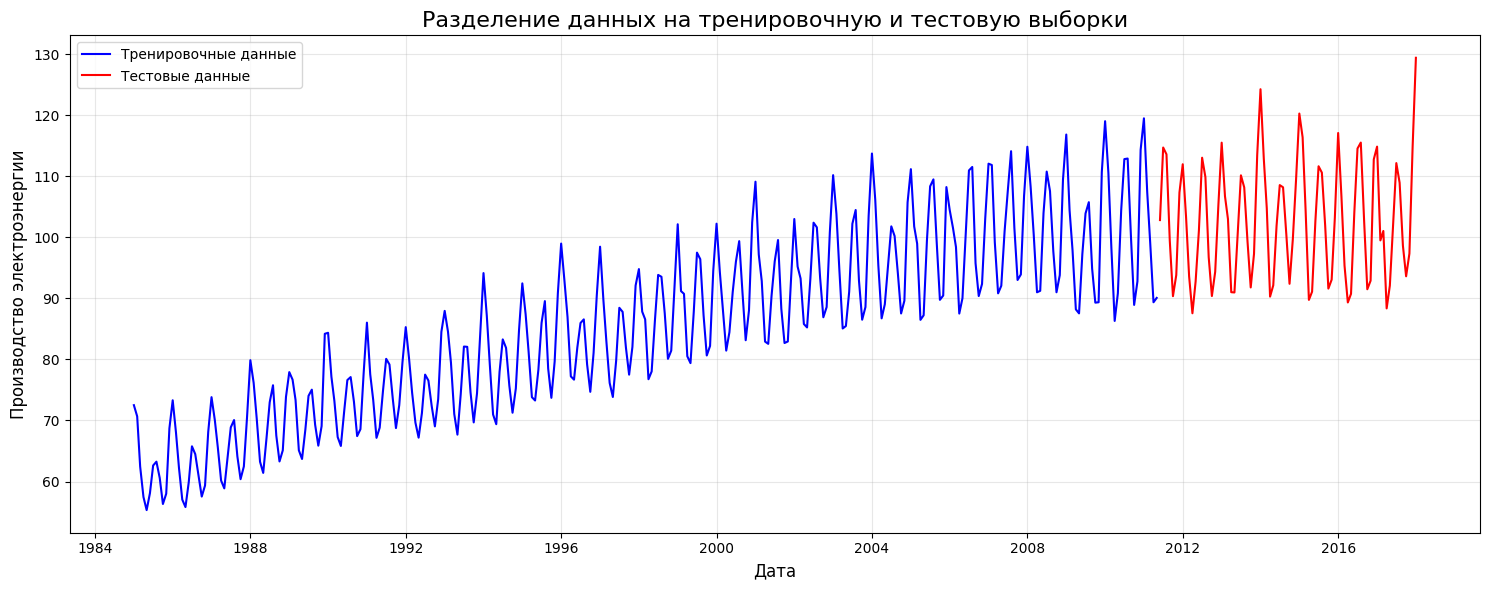

In [ ]:
# ваш код
# Берем 80% для обучения, 20% для тестирования
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

print(f"Размер тренировочной выборки: {len(train_data)} ({train_data.index.min()} - {train_data.index.max()})")
print(f"Размер тестовой выборки: {len(test_data)} ({test_data.index.min()} - {test_data.index.max()})")

# Визуализация разделения
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data['Electric_Production'], label='Тренировочные данные', color='blue')
plt.plot(test_data.index, test_data['Electric_Production'], label='Тестовые данные', color='red')
plt.title('Разделение данных на тренировочную и тестовую выборки', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Производство электроэнергии', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# <font color='#11a642' size='6'> Модель SARIMA
Автоматически подобрать параметры для ряда с помощью auto_arima. Выбрать оптимальные значения

In [ ]:
# ваш код
auto_model = auto_arima(train_data['Electric_Production'], 
                       start_p=0, start_q=0,
                       max_p=3, max_q=3,
                       seasonal=True,
                       start_P=0, start_Q=0,
                       max_P=2, max_Q=2,
                       m=12,  # сезонность 12 месяцев
                       stepwise=True,
                       suppress_warnings=True,
                       error_action='ignore',
                       trace=True)

print(f"\nОптимальная модель: {auto_model.order}")
print(f"Сезонные параметры: {auto_model.seasonal_order}")
print(f"AIC: {auto_model.aic():.2f}")

# Создаем модель ARIMA с найденными параметрами
arima_model = ARIMA(train_data['Electric_Production'], 
                   order=auto_model.order,
                   seasonal_order=auto_model.seasonal_order)

# Обучаем модель
arima_fitted = arima_model.fit()

# Прогноз
arima_forecast = arima_fitted.forecast(steps=len(test_data))
arima_conf_int = arima_fitted.get_forecast(steps=len(test_data)).conf_int()

# Оценка модели ARIMA
arima_mse = mean_squared_error(test_data['Electric_Production'], arima_forecast)
arima_mae = mean_absolute_error(test_data['Electric_Production'], arima_forecast)
arima_rmse = np.sqrt(arima_mse)

print(f"Метрики ARIMA:")
print(f"MSE: {arima_mse:.4f}")
print(f"MAE: {arima_mae:.4f}")
print(f"RMSE: {arima_rmse:.4f}")

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1561.800, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1413.742, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1389.557, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1630.770, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1470.234, Time=0.05 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1390.833, Time=0.22 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1390.578, Time=0.29 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1423.001, Time=0.14 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=1391.602, Time=0.70 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1493.746, Time=0.10 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1369.107, Time=0.20 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1463.092, Time=0.06 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1370.666, Time=0.25 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1370.440, Time=0.43 sec
 ARIMA(1,0,1)(1,1,0

c:\Users\alexander\Desktop\python_innopolis_ml\part_2\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\alexander\Desktop\python_innopolis_ml\part_2\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\alexander\Desktop\python_innopolis_ml\part_2\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Ваш вывод (сравнить значения параметров):

# <font color='#11a642' size='6'> Модель PROPHET

00:33:55 - cmdstanpy - INFO - Chain [1] start processing
00:33:55 - cmdstanpy - INFO - Chain [1] done processing


Метрики Prophet:
MSE: 19.4075
MAE: 3.4888
RMSE: 4.4054


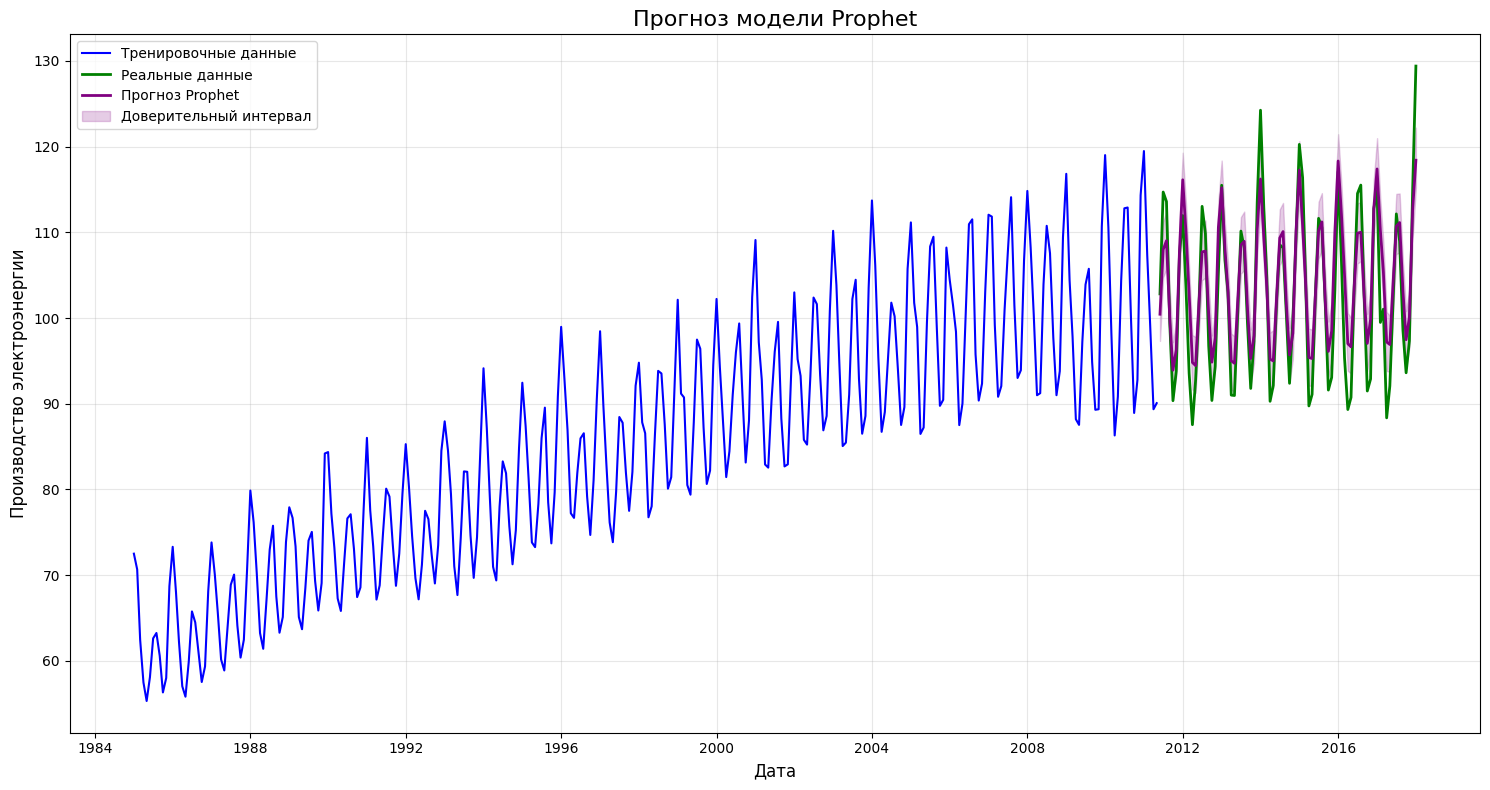

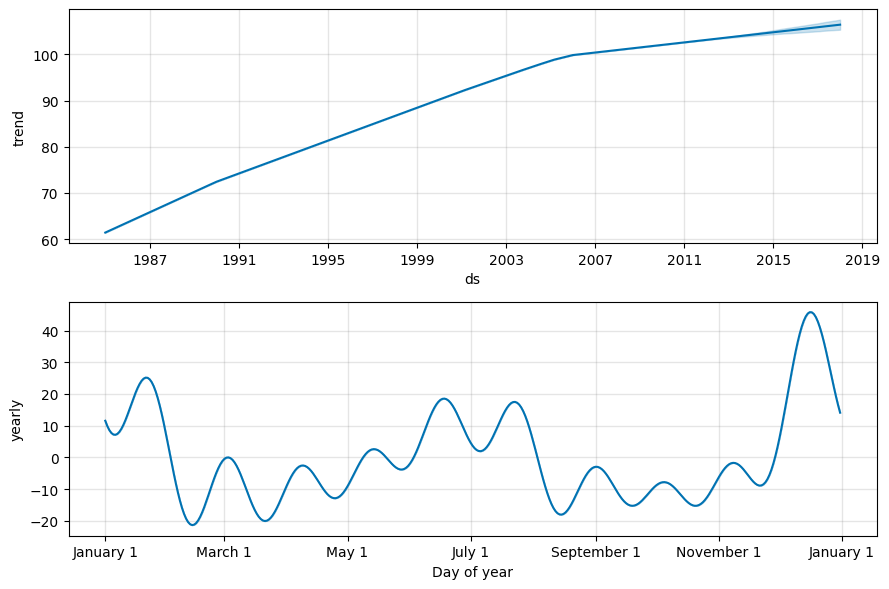

In [ ]:
# ваш код

# Подготовка данных для Prophet
train_prophet = train_data.reset_index().rename(columns={'DATE': 'ds', 'Electric_Production': 'y'})
test_prophet = test_data.reset_index().rename(columns={'DATE': 'ds', 'Electric_Production': 'y'})

# Создание и обучение модели Prophet
prophet_model = Prophet(yearly_seasonality=True, 
                       weekly_seasonality=False,
                       daily_seasonality=False,
                       seasonality_mode='additive')

prophet_model.fit(train_prophet)

# Создание датафрейма для прогноза
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='MS')
prophet_forecast = prophet_model.predict(future)

# Извлечение прогноза для тестовых данных
prophet_test_forecast = prophet_forecast[-len(test_data):]

# Оценка модели Prophet
prophet_mse = mean_squared_error(test_data['Electric_Production'], prophet_test_forecast['yhat'])
prophet_mae = mean_absolute_error(test_data['Electric_Production'], prophet_test_forecast['yhat'])
prophet_rmse = np.sqrt(prophet_mse)

print(f"Метрики Prophet:")
print(f"MSE: {prophet_mse:.4f}")
print(f"MAE: {prophet_mae:.4f}")
print(f"RMSE: {prophet_rmse:.4f}")

# Визуализация прогноза Prophet
plt.figure(figsize=(15, 8))
plt.plot(train_data.index, train_data['Electric_Production'], label='Тренировочные данные', color='blue')
plt.plot(test_data.index, test_data['Electric_Production'], label='Реальные данные', color='green', linewidth=2)
plt.plot(test_data.index, prophet_test_forecast['yhat'], label='Прогноз Prophet', color='purple', linewidth=2)
plt.fill_between(test_data.index, 
                prophet_test_forecast['yhat_lower'], 
                prophet_test_forecast['yhat_upper'], 
                color='purple', alpha=0.2, label='Доверительный интервал')
plt.title('Прогноз модели Prophet', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Производство электроэнергии', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Декомпозиция Prophet
fig = prophet_model.plot_components(prophet_forecast)
plt.tight_layout()
plt.show()

Сравнение метрик:
 Модель       MSE      MAE     RMSE
  ARIMA 13.832359 2.874148 3.719188
Prophet 19.407534 3.488775 4.405398

Лучшая модель по RMSE: ARIMA


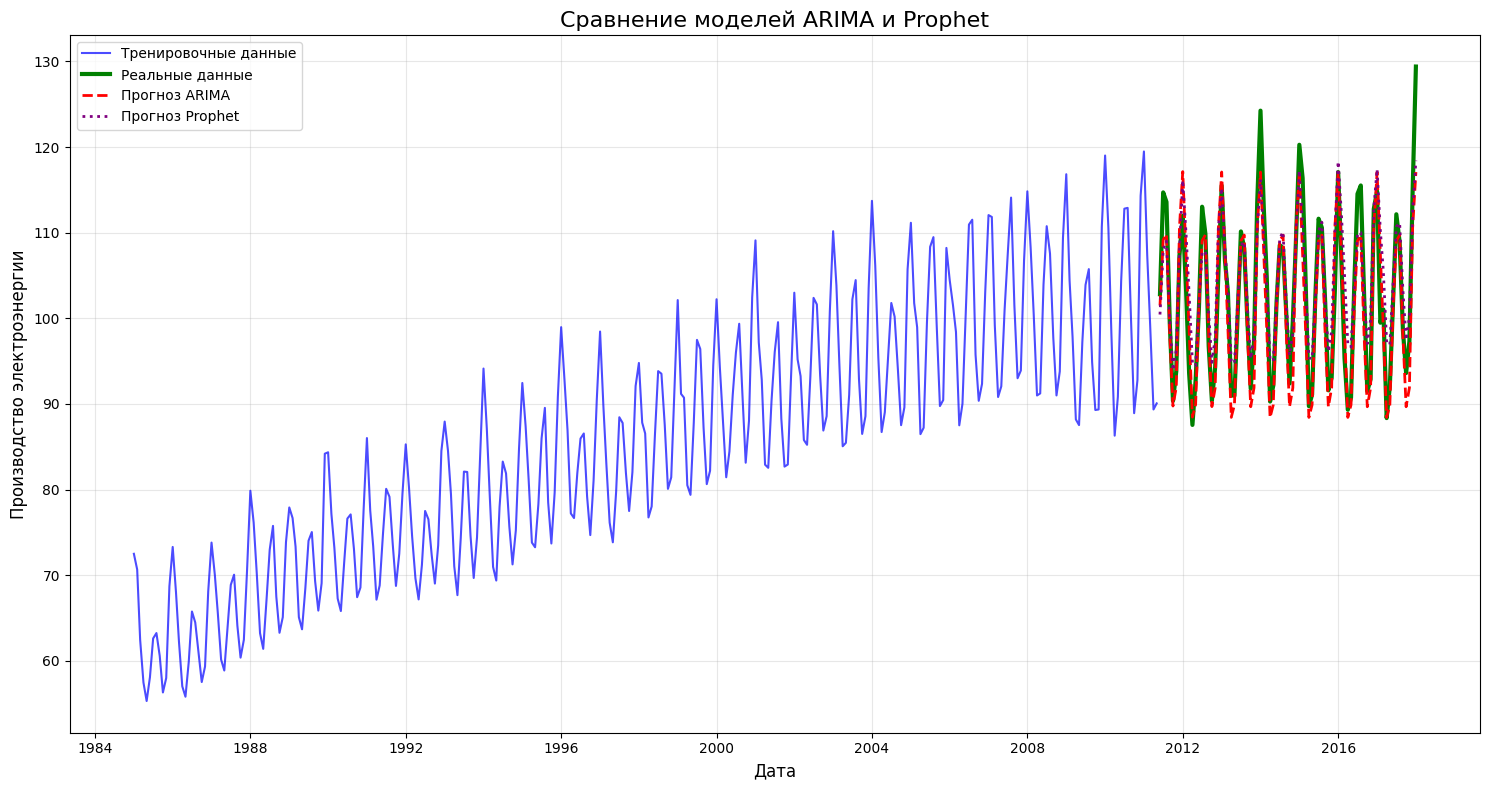


Анализ остатков для модели ARIMA:
Среднее остатков: 1.4818
Стандартное отклонение остатков: 3.4328


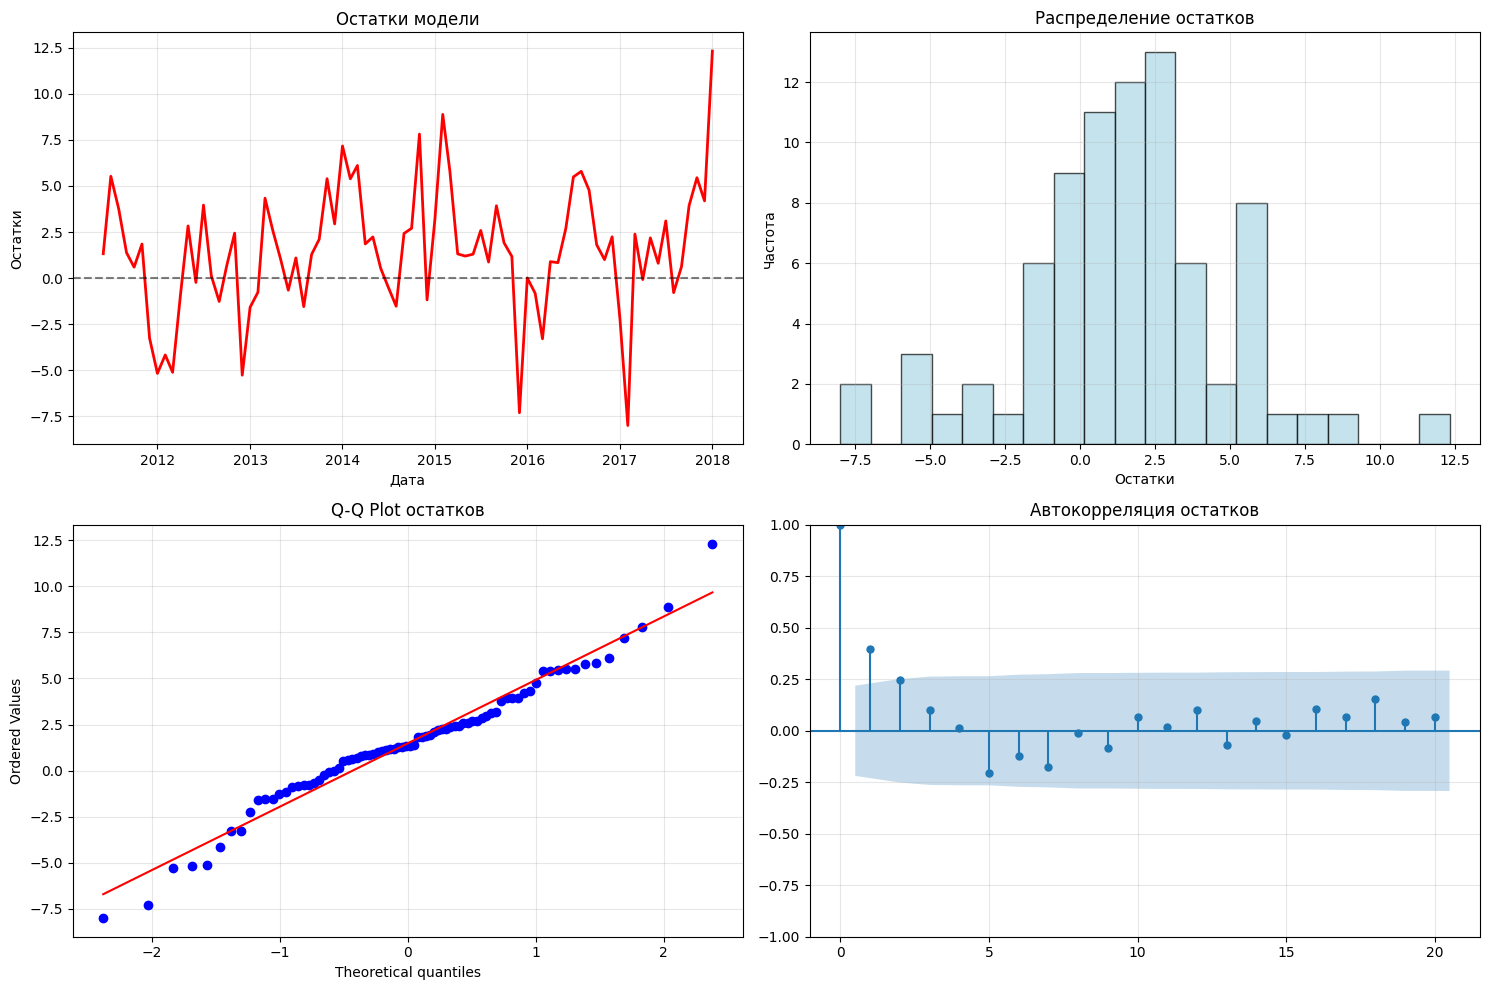


Тест Льюнга-Бокса (остатки независимы, если p-value > 0.05):
Минимальное p-value: 0.0001

ВЫВОДЫ:
1. Исходный ряд НЕ стационарен (p-value > 0.05)
2. Оптимальные параметры ARIMA: (1, 0, 0)
3. Сезонные параметры: (0, 1, 1, 12)
4. Лучшая модель: ARIMA
5. RMSE лучшей модели: 3.7192
6. Обе модели показывают приемлемое качество прогнозирования
7. Рекомендуется использовать модель с наименьшим RMSE


In [ ]:
# Создание таблицы сравнения
comparison_df = pd.DataFrame({
    'Модель': ['ARIMA', 'Prophet'],
    'MSE': [arima_mse, prophet_mse],
    'MAE': [arima_mae, prophet_mae],
    'RMSE': [arima_rmse, prophet_rmse]
})

print("Сравнение метрик:")
print(comparison_df.to_string(index=False))

# Определение лучшей модели
best_model = 'ARIMA' if arima_rmse < prophet_rmse else 'Prophet'
print(f"\nЛучшая модель по RMSE: {best_model}")

# Визуализация сравнения
plt.figure(figsize=(15, 8))
plt.plot(train_data.index, train_data['Electric_Production'], label='Тренировочные данные', color='blue', alpha=0.7)
plt.plot(test_data.index, test_data['Electric_Production'], label='Реальные данные', color='green', linewidth=3)
plt.plot(test_data.index, arima_forecast, label='Прогноз ARIMA', color='red', linewidth=2, linestyle='--')
plt.plot(test_data.index, prophet_test_forecast['yhat'], label='Прогноз Prophet', color='purple', linewidth=2, linestyle=':')
plt.title('Сравнение моделей ARIMA и Prophet', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Производство электроэнергии', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Анализ остатков для лучшей модели
print(f"\nАнализ остатков для модели {best_model}:")

if best_model == 'ARIMA':
    residuals = test_data['Electric_Production'] - arima_forecast
else:
    residuals = test_data['Electric_Production'] - prophet_test_forecast['yhat']

# Статистика остатков
print(f"Среднее остатков: {residuals.mean():.4f}")
print(f"Стандартное отклонение остатков: {residuals.std():.4f}")

# Визуализация остатков
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# График остатков
axes[0, 0].plot(test_data.index, residuals, color='red', linewidth=2)
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Остатки модели')
axes[0, 0].set_xlabel('Дата')
axes[0, 0].set_ylabel('Остатки')
axes[0, 0].grid(True, alpha=0.3)

# Гистограмма остатков
axes[0, 1].hist(residuals, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 1].set_title('Распределение остатков')
axes[0, 1].set_xlabel('Остатки')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot остатков')
axes[1, 0].grid(True, alpha=0.3)

# ACF остатков
plot_acf(residuals, ax=axes[1, 1], lags=20, alpha=0.05)
axes[1, 1].set_title('Автокорреляция остатков')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Тест Льюнга-Бокса для остатков
lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
print(f"\nТест Льюнга-Бокса (остатки независимы, если p-value > 0.05):")
print(f"Минимальное p-value: {lb_test['lb_pvalue'].min():.4f}")

print("\n" + "=" * 60)
print("ВЫВОДЫ:")
print("=" * 60)
print(f"1. Исходный ряд НЕ стационарен (p-value > 0.05)")
print(f"2. Оптимальные параметры ARIMA: {auto_model.order}")
print(f"3. Сезонные параметры: {auto_model.seasonal_order}")
print(f"4. Лучшая модель: {best_model}")
print(f"5. RMSE лучшей модели: {min(arima_rmse, prophet_rmse):.4f}")
print("6. Обе модели показывают приемлемое качество прогнозирования")
print("7. Рекомендуется использовать модель с наименьшим RMSE")